# Mocap pose data to bagfile

This notebook converts csv formatted pose data exported from a motive mocap TAK file data into a tf message in a ROS bagfile. 
Assuming the csv file looks like so:
```
Format Version,1.1,Take Name,Jeeves_test,Capture Frame Rate,120.000000,Export Frame Rate,120.000000,Capture Start Time,2016-02-04 07.20.44.718 PM,Total Frames,2173,Rotation Type,Quaternion

,,Rigid Body,Rigid Body,Rigid Body,Rigid Body,Rigid Body,Rigid Body,Rigid Body,Rigid Body
,,Rigid Body 1,Rigid Body 1,Rigid Body 1,Rigid Body 1,Rigid Body 1,Rigid Body 1,Rigid Body 1,Rigid Body 1
,,"C7CFB647CA0F11E56E6FD9C3D17CA8A3","C7CFB647CA0F11E56E6FD9C3D17CA8A3","C7CFB647CA0F11E56E6FD9C3D17CA8A3","C7CFB647CA0F11E56E6FD9C3D17CA8A3","C7CFB647CA0F11E56E6FD9C3D17CA8A3","C7CFB647CA0F11E56E6FD9C3D17CA8A3","C7CFB647CA0F11E56E6FD9C3D17CA8A3","C7CFB647CA0F11E56E6FD9C3D17CA8A3"
,,Rotation,Rotation,Rotation,Rotation,Position,Position,Position,Error Per Marker
Frame,Time,X,Y,Z,W,X,Y,Z,
0,0.000000,0.001154,0.007851,-0.002402,0.999966,-1.395789,0.790427,0.443426,0.000296
1,0.008333,0.001172,0.007781,-0.002358,0.999966,-1.395765,0.790421,0.443417,0.000296
2,0.016667,0.001205,0.007746,-0.002356,0.999967,-1.395745,0.790440,0.443396,0.000299
```

In [1]:
import geometry_msgs
import pandas as pd
import rosbag
import rospy
import tf

## Configure parameters

In [2]:
offset = 0 # in seconds 
csv_pose_file = "../Data/Jeeves_test/Jeeves_test.csv"
header_length = 7
output_bag = "/tmp/output_bag.bag"
frame_id = "world"
child_frame_id = "mocap"

## Read file info

In [3]:
# Read first line for file info from header
with open(csv_pose_file, 'r') as f:
    pose_file_info = f.readline().split('\r')[0].split(',')

# Convert line to dict
keys = pose_file_info[::2]
values = pose_file_info[1::2]
pose_info = dict(zip(keys, values))

# Parse the capture start time
date_format = '%Y-%m-%d %I.%M.%S.%f %p'
pose_info['Capture Start Datetime'] = pd.to_datetime(pose_info['Capture Start Time'], format=date_format)
print('Capture Start Datetime: ', pose_info['Capture Start Datetime'])

('Capture Start Datetime: ', Timestamp('2016-02-04 19:20:44.718000', tz=None))


## Read file data

In [4]:
names=['frame_id','time',
       'rotation.x','rotation.y','rotation.z','rotation.w',
       'translation.x','translation.y','translation.z',
       'error_per_marker']
pose_df = pd.read_csv(csv_pose_file, skiprows=header_length, names=names, index_col='frame_id')
pose_df['datetime'] = pd.to_datetime(pose_df['time'], unit='s')
pose_timedelta = pose_info['Capture Start Datetime'] - pose_df['datetime'][0]
pose_df['datetime'] = pose_df['datetime'] + pose_timedelta + pd.datetools.timedelta(seconds=offset)

## View data

In [5]:
pose_df.head()

,time,rotation.x,rotation.y,rotation.z,rotation.w,translation.x,translation.y,translation.z,error_per_marker,datetime
frame_id,,,,,,,,,,
0,0.000000,0.001154,0.007851,-0.002402,0.999966,-1.395789,0.790427,0.443426,0.000296,2016-02-04 19:20:44.718000
1,0.008333,0.001172,0.007781,-0.002358,0.999966,-1.395765,0.790421,0.443417,0.000296,2016-02-04 19:20:44.726333
2,0.016667,0.001205,0.007746,-0.002356,0.999967,-1.395745,0.790440,0.443396,0.000299,2016-02-04 19:20:44.734667
3,0.025000,0.001267,0.007711,-0.002414,0.999967,-1.395738,0.790451,0.443383,0.000290,2016-02-04 19:20:44.743000
4,0.033333,0.001185,0.007789,-0.002403,0.999966,-1.395774,0.790434,0.443407,0.000298,2016-02-04 19:20:44.751333


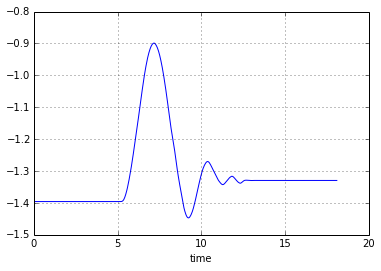

In [6]:
%matplotlib inline
pose_df.set_index('time')['translation.x'].plot()

## Save to bagfile

In [7]:
with rosbag.Bag(output_bag, 'w') as outbag:
    for index, row in pose_df.iterrows():
        # create TF msg 
        tf_msg = tf.msg.tfMessage()
        geo_msg = geometry_msgs.msg.TransformStamped()
        ros_time_stamp = rospy.Time.from_sec((row['datetime'] - pd.datetools.datetime(1970,1,1)).total_seconds())
        geo_msg.header.stamp = ros_time_stamp
        geo_msg.header.seq = index
        geo_msg.header.frame_id = frame_id
        geo_msg.child_frame_id = child_frame_id
        geo_msg.transform.translation.x = row['translation.x']
        geo_msg.transform.translation.y = row['translation.y']
        geo_msg.transform.translation.z = row['translation.z']
        geo_msg.transform.rotation.x = row['rotation.x']
        geo_msg.transform.rotation.y = row['rotation.y']
        geo_msg.transform.rotation.z = row['rotation.z']
        geo_msg.transform.rotation.w = row['rotation.w']
        tf_msg.transforms.append(geo_msg)
        outbag.write('/tf', tf_msg, geo_msg.header.stamp)